## BTC-ETH Ratio Strategy

In [8]:
from datetime import datetime

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import backtrader.feeds as btfeeds
import numpy as np
import matplotlib.pylab as pylab
import pyfolio as pf


In [9]:
class Indicator(bt.Indicator):
    lines = ('z', )
    win_size = 20

    def next(self):
        if len(self) > self.win_size:
            avg = np.mean(self.data.get(size=self.win_size))
            std = np.std(self.data.get(size=self.win_size))
            self.z[0] = (self.data[0] - avg) / std

### Strategy

In [10]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        """ Logging function for this strategy """
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        # import pdb; pdb.set_trace()
        self.btc = self.datas[0]
        self.eth = self.datas[1]
        self.myind = Indicator(self.btc / self.eth)
        self.signal = 0
        self.orders = []

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # import pdb; pdb.set_trace()
        if order.status == order.Canceled:
            self.log('Order Canceled')
        elif order.status == order.Margin:
            self.log('Order margin')
        elif order.status == order.Rejected:
            self.log('Order rejected')
        self.orders.remove(order)
        #self.orders = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])
        #self.log(f"BTC: {self.btc[0]} ; ETH: {self.eth[0]} {len(self.btc)}")
        #self.log(self.datas[0][0])
        entry_threshold = 1
        trade_amount = self.broker.get_cash() * .5

        if len(self.orders) > 0:
            self.log("order pending")
            return

        if self.signal == 0:
            if self.myind.z > entry_threshold:
                self.log(f"ENTRY LONG b: {self.btc[0]} e: {self.eth[0]} z: {self.myind.z[0]}")
                # import pdb; pdb.set_trace()
                self.orders.append(self.buy(self.btc, size=trade_amount / self.btc[0]))
                self.orders.append(self.sell(self.eth, size=trade_amount / self.eth[0]))
                self.signal = 1
            elif self.myind.z < -entry_threshold:
                self.log(f"ENTRY SHORT b: {self.btc[0]} e: {self.eth[0]} z: {self.myind.z[0]}")
                # import pdb; pdb.set_trace()
                self.orders.append(self.sell(self.btc, size=trade_amount / self.btc[0]))
                self.orders.append(self.buy(self.eth, size=trade_amount / self.eth[0]))
                self.signal = -1
        elif self.signal == 1:
            if self.myind.z < 0:
                self.log("CLOSE LONG")
                self.orders.append(self.close(self.btc))
                self.orders.append(self.close(self.eth))
                self.signal = 0
        elif self.signal == -1:
            if self.myind.z > 0:
                self.log("CLOSE SHORT")
                self.orders.append(self.close(self.btc))
                self.orders.append(self.close(self.eth))
                self.signal = 0

### Back-test

In [11]:
btc = pd.read_pickle('BTC.pd')  # .iloc[:60]
eth = pd.read_pickle('ETH.pd')  # .iloc[:60]

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(btfeeds.PandasData(dataname=btc))
cerebro.adddata(btfeeds.PandasData(dataname=eth))
cerebro.broker.set_cash(10000)
cerebro.addanalyzer(btanalyzers.SharpeRatio)
cerebro.addanalyzer(bt.analyzers.PyFolio)
# cerebro.broker.set_checksubmit(False)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()

Starting Portfolio Value: 10000.00
2017-08-16, ENTRY LONG b: 4280.01 e: 300.67 z: 1.2303721754558792
2017-08-20, CLOSE LONG
2017-08-29, ENTRY SHORT b: 4581.98 e: 384.1 z: -1.55905357640736
2017-09-03, CLOSE SHORT
2017-09-04, ENTRY LONG b: 4432.51 e: 320.08 z: 1.0588970997658869
2017-09-19, CLOSE LONG
2017-09-22, ENTRY SHORT b: 3787.33 e: 286.03 z: -2.382532382391025
2017-09-28, CLOSE SHORT
2017-09-29, ENTRY LONG b: 4339.0 e: 301.57 z: 1.1265241376459314
2017-11-10, CLOSE LONG
2017-11-11, ENTRY SHORT b: 5886.35 e: 307.1 z: -1.1935960393254954
2017-11-14, CLOSE SHORT
2017-11-22, ENTRY SHORT b: 8031.16 e: 406.61 z: -1.5262377265609983
2017-11-27, CLOSE SHORT
2017-11-28, ENTRY LONG b: 9935.98 e: 434.01 z: 1.0754036616284506
2017-12-11, CLOSE LONG
2017-12-18, ENTRY SHORT b: 17838.73 e: 826.65 z: -1.1944265391803273
2018-02-07, CLOSE SHORT
2018-02-13, ENTRY LONG b: 9472.98 e: 920.26 z: 1.0669218337083215
2018-04-08, CLOSE LONG
2018-04-09, ENTRY SHORT b: 6824.99 e: 415.45 z: -1.29779003323098

### Pyfolio Reports

/home/a/.local/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/a/.local/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/a/.local/lib/python3.8/site-packages/empyrical/stats.py:1529: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(np.percentile(returns, 95)) / np.abs(


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.58,2021-05-13,2021-07-30,NaT,NaN
1,21.78,2017-11-04,2017-11-29,2017-12-06,23
2,19.97,2017-12-06,2017-12-12,2018-01-07,23
3,19.53,2020-08-13,2021-01-07,2021-02-02,124
4,18.54,2017-08-16,2017-10-05,2017-10-30,54


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 76.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.11%,-12.59%,13.91%


Top 10 long positions of all time,max
Data1,52.12%


Top 10 short positions of all time,max
Data1,-377.66%


Top 10 positions of all time,max
Data1,377.66%


/usr/local/lib/python3.8/dist-packages/pyfolio/round_trips.py:321: RuntimeWarning: divide by zero encountered in double_scalars
  ending_price = ending_val / ending_amount


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,76.00,43.00,33.00
Percent profitable,0.39,0.30,0.52
Winning round_trips,30.00,13.00,17.00
Losing round_trips,46.00,30.00,16.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$6307.08,$-25885.81,$32192.89
Gross profit,$70558.20,$21661.33,$48896.87
Gross loss,$-64251.12,$-47547.14,$-16703.98
Profit factor,$1.10,$0.46,$2.93
Avg. trade net profit,$82.99,$-602.00,$975.54
Avg. winning trade,$2351.94,$1666.26,$2876.29
Avg. losing trade,$-1396.76,$-1584.90,$-1044.00
Ratio Avg. Win:Avg. Loss,$1.68,$1.05,$2.76
Largest winning trade,$12082.58,$4197.28,$12082.58
Largest losing trade,$-9590.84,$-9590.84,$-4215.15


Duration stats,All trades,Short trades,Long trades
Avg duration,16 days 04:06:18.947368421,16 days 09:29:18.139534883,15 days 21:05:27.272727272
Median duration,13 days 00:00:00,13 days 00:00:00,11 days 00:00:00
Longest duration,54 days 01:00:00,54 days 01:00:00,51 days 00:00:00
Shortest duration,1 days 00:00:00,2 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.23%,-1.58%,2.58%
Avg returns winning,8.32%,7.70%,8.79%
Avg returns losing,-5.05%,-5.60%,-4.02%
Median returns all round_trips,-1.05%,-2.08%,0.69%
Median returns winning,6.16%,5.80%,6.52%
Median returns losing,-3.43%,-3.43%,-3.28%
Largest winning trade,29.15%,19.00%,29.15%
Largest losing trade,-25.82%,-25.82%,-10.83%


Symbol stats,
Avg returns all round_trips,0.23%
Avg returns winning,8.32%
Avg returns losing,-5.05%
Median returns all round_trips,-1.05%
Median returns winning,6.16%
Median returns losing,-3.43%
Largest winning trade,29.15%
Largest losing trade,-25.82%


Profitability (PnL / PnL total) per name,
symbol,
,100.00%


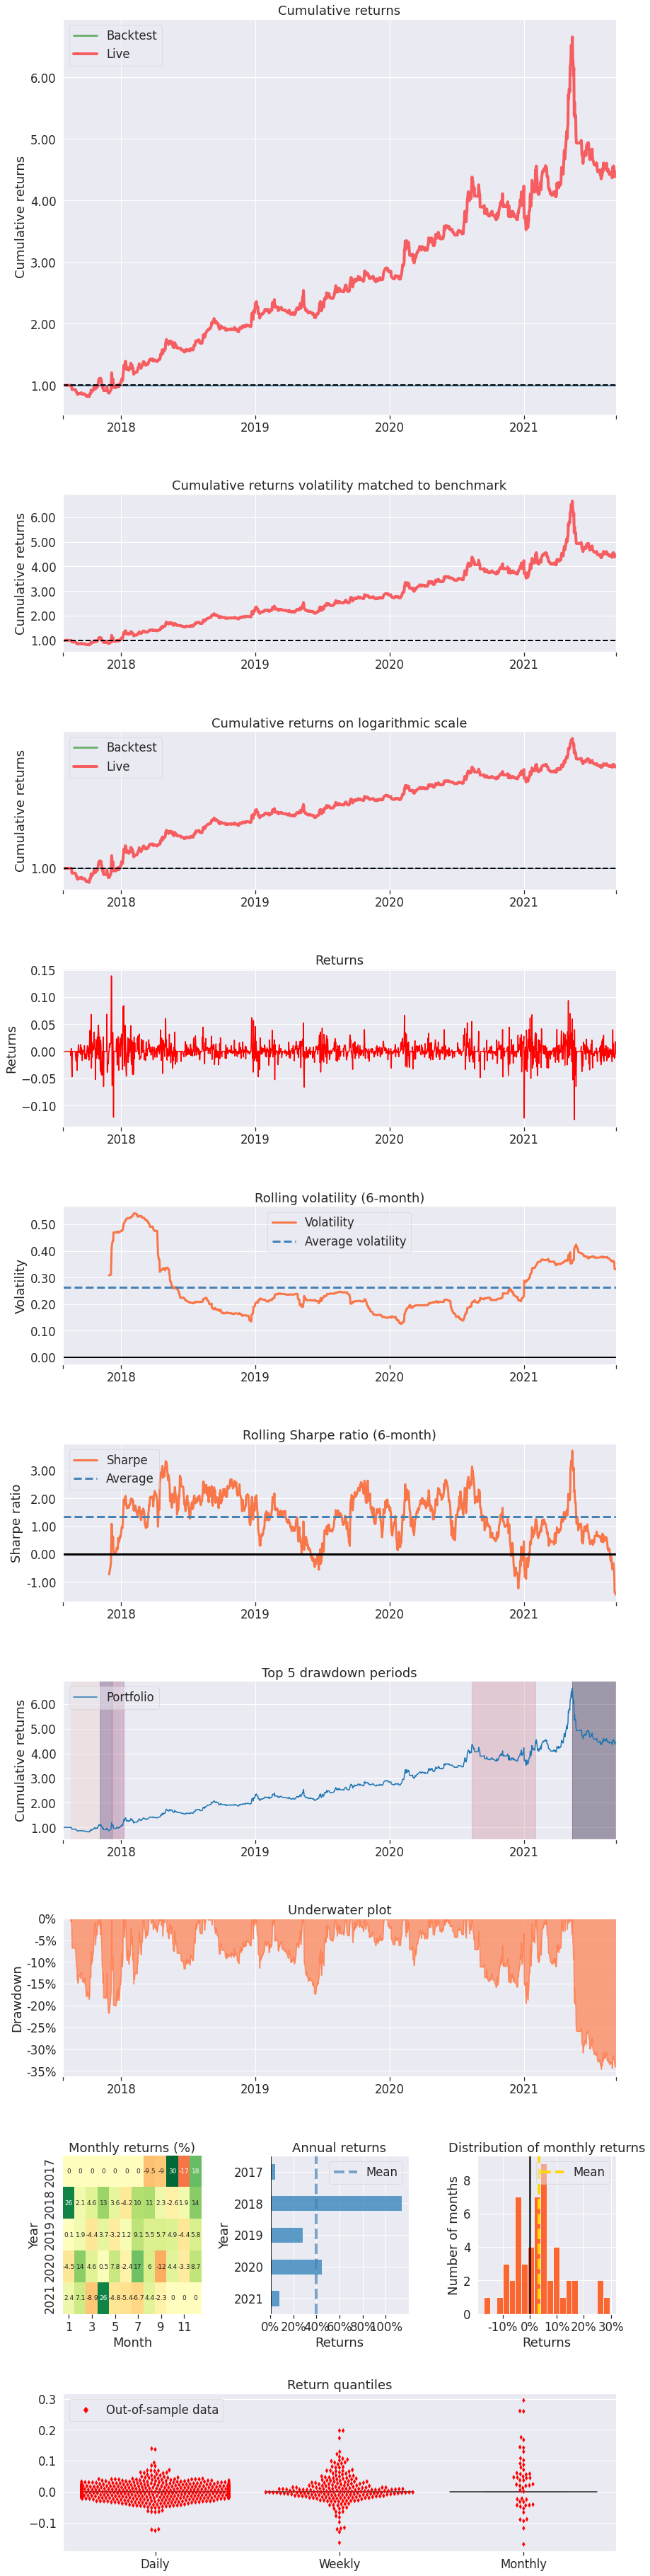

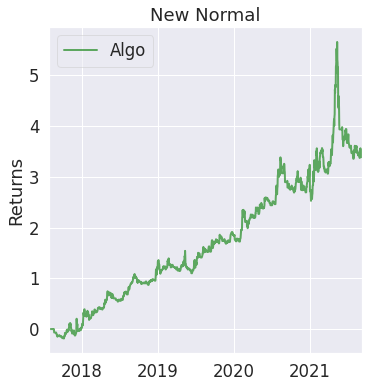

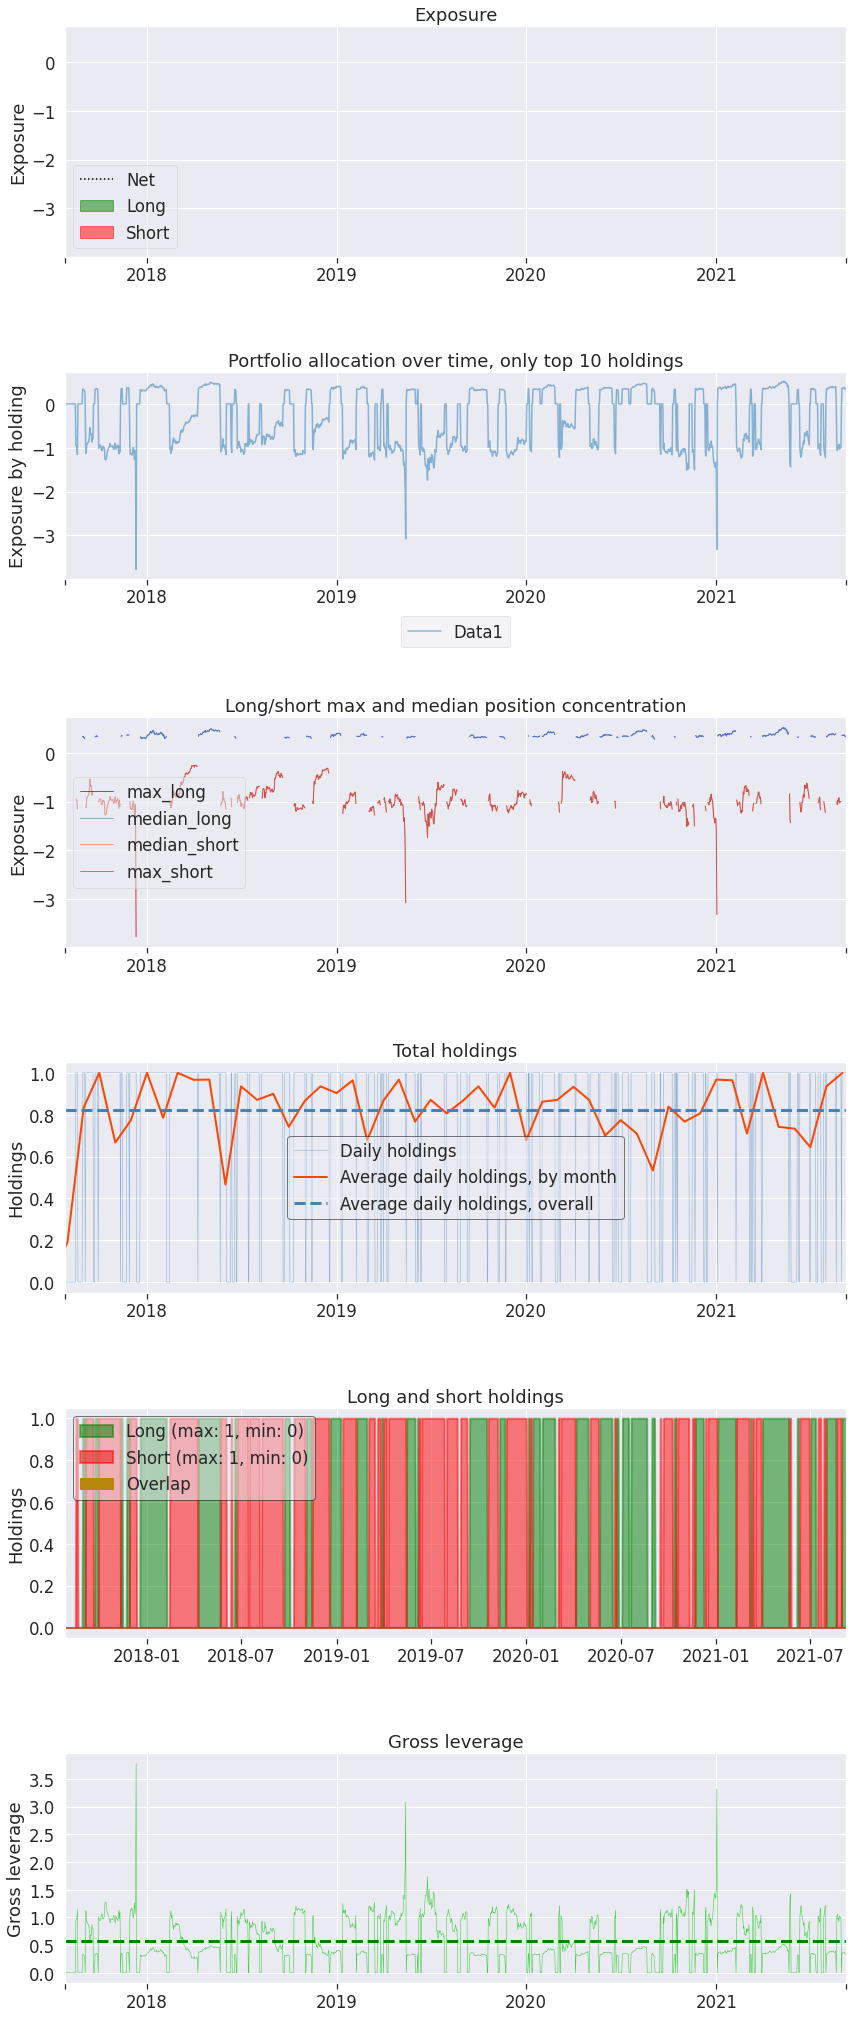

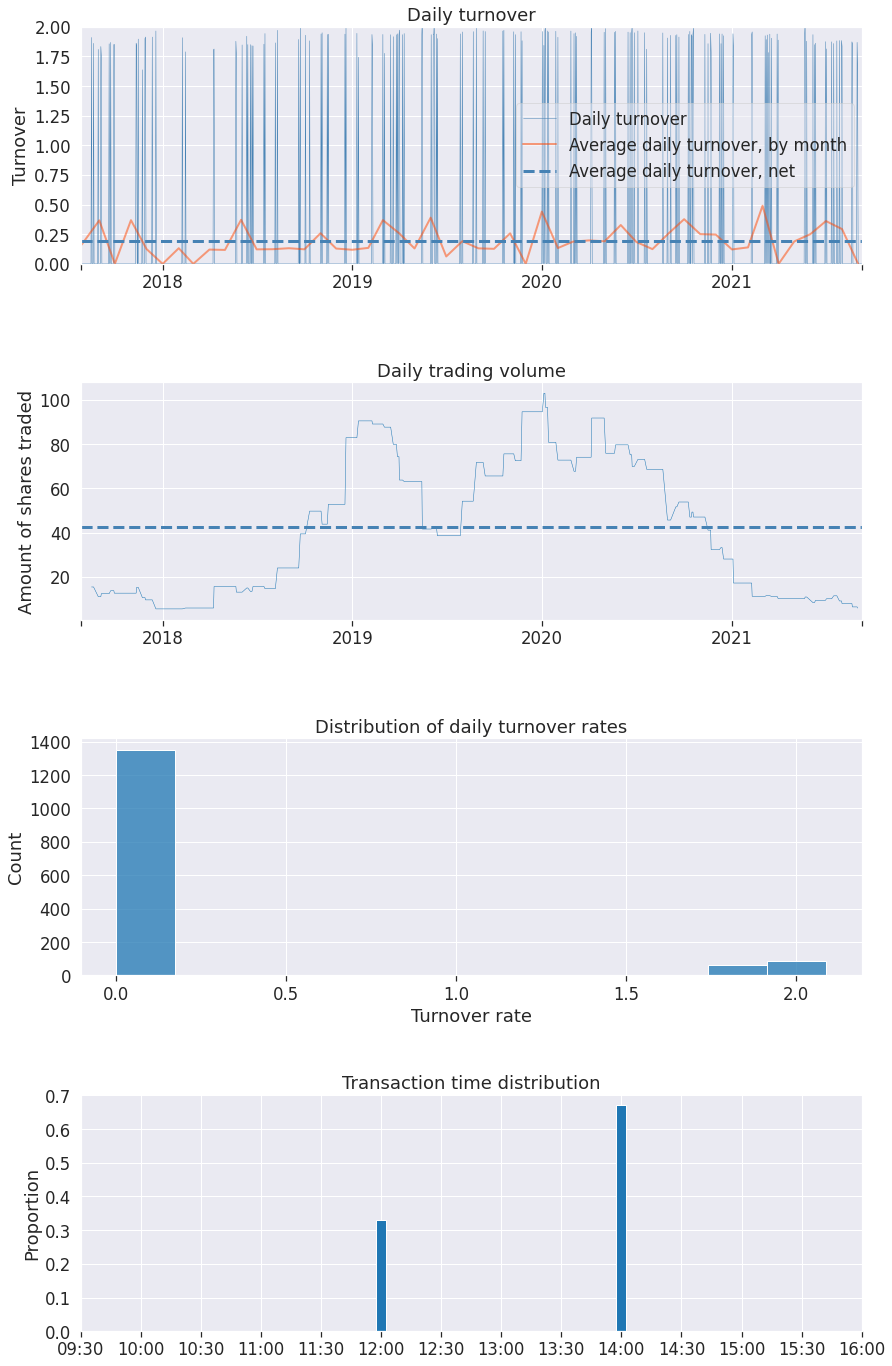

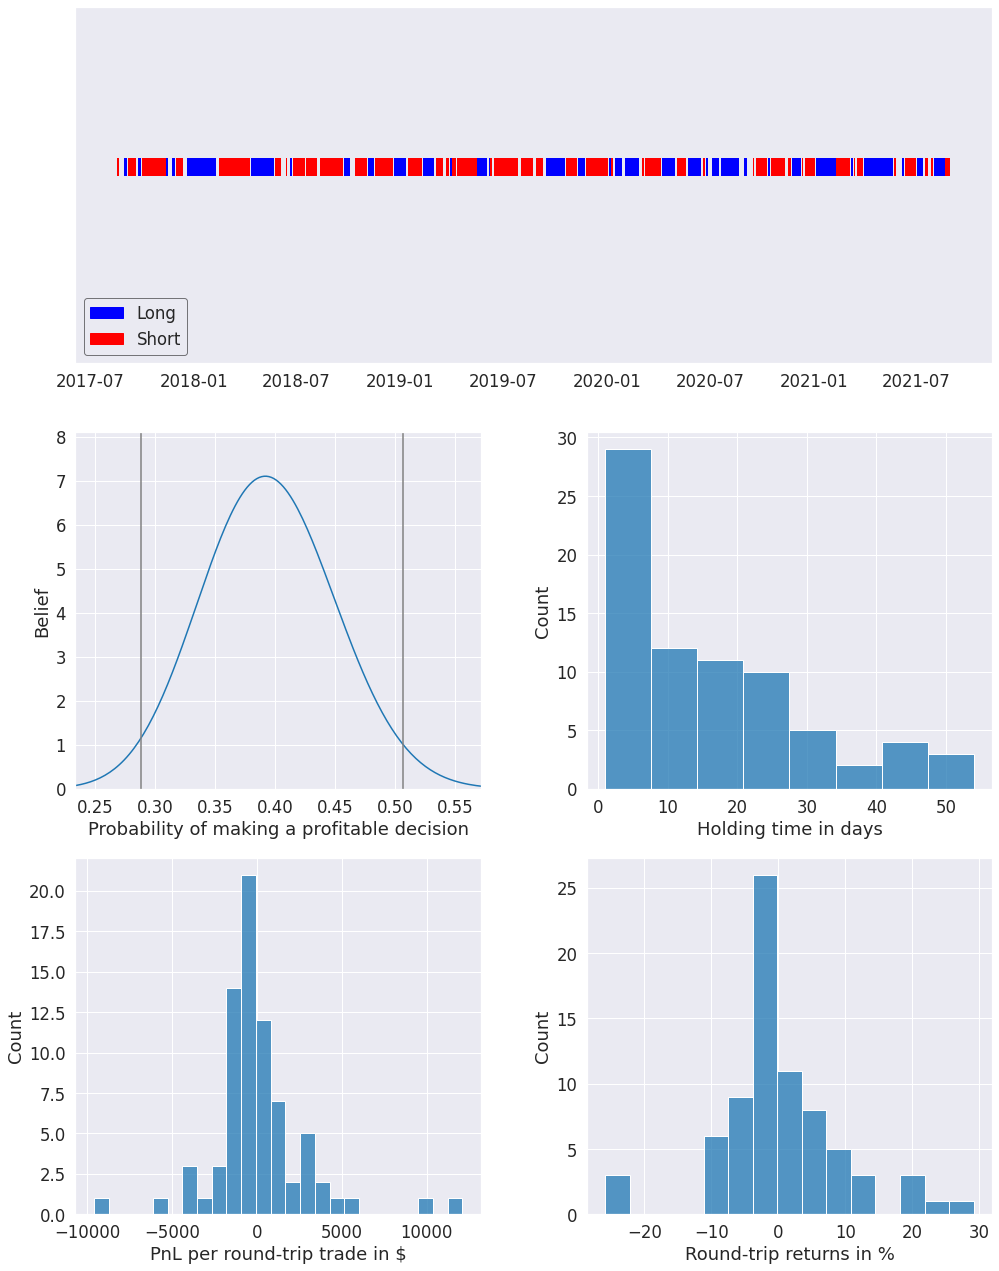

In [12]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

try:
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date=datetime(2017, 8, 1),
        round_trips=True)
except IndexError:
        print("live_start_date is out of the range of the date you had in your dataset.")
        quit(1)

### Final Report

In [13]:
ind = results[0].myind.z.array
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print(f"Sharpe: {results[0].analyzers[0].get_analysis()}")

Final Portfolio Value: 44419.30
Sharpe: OrderedDict([('sharperatio', 0.9684366545332975)])


### Backtrader Chart

<IPython.core.display.Javascript object>

[[<Figure size 864x576 with 7 Axes>]]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


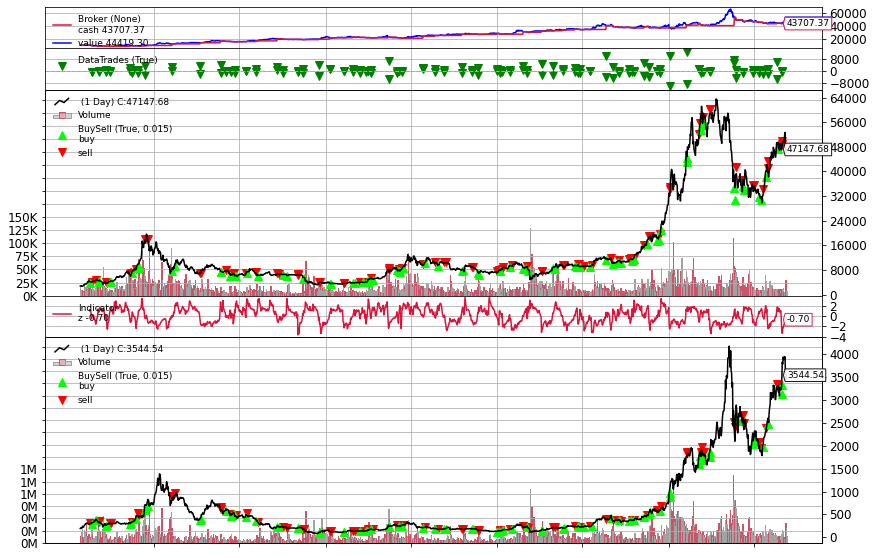

In [14]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Sans-Serif']
pylab.rcParams['font.serif'] = ['Sans-Serif']
pylab.rcParams["font.size"] = "12"

cerebro.plot()